In [1]:
import numpy as np
import pandas as pd

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='paper', style='whitegrid', rc={'figure.figsize':(8, 5), 'figure.dpi': 120})
color_palette = sns.color_palette("Set2")
sns.set_palette(color_palette)

seed_ = 20200218
np.random.seed(seed_)

import tensorflow as tf
import keras
tf.random.set_seed(seed_)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from keras.models import Sequential
from keras.layers import Dense, LSTM, Lambda, Conv1D
from keras.optimizers import *

In [2]:
df = pd.read_csv("./data/climate-data/tavg_clean.csv")

In [3]:
df.head()

,DATE,TAVG,tas
0,1973-01-01,20.5,14.9445
1,1973-01-02,20.4,12.7787
2,1973-01-03,21.2,12.3004
3,1973-01-04,20.7,12.9918
4,1973-01-05,21.8,14.2838


In [4]:
df.isna().sum()

DATE    0
TAVG    0
tas     0
dtype: int64

## function

In [5]:
def mae(a, b):
    return np.mean(np.abs(a - b))

In [6]:
# bias of model and observed temperature
mae(df['TAVG'], df['tas'])

3.892691844354082

## EDA

#### plot all data

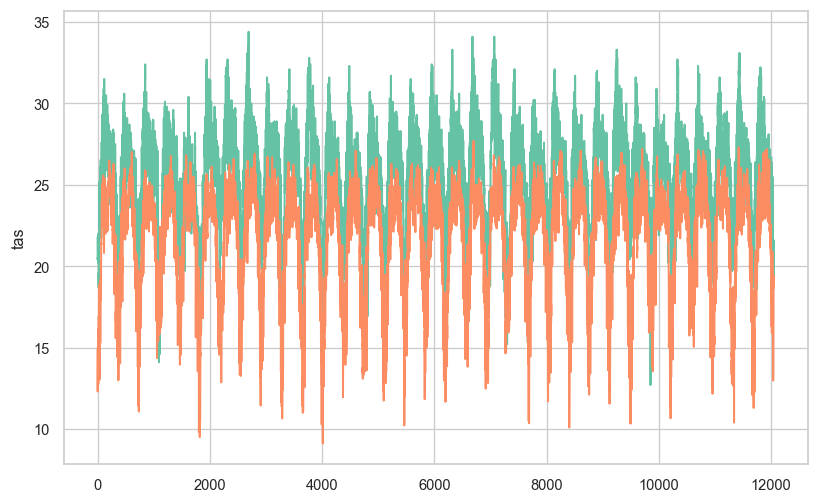

In [7]:
sample_size = len(df)

sns.lineplot(np.arange(sample_size), df['TAVG'])
sns.lineplot(np.arange(sample_size), df['tas'])
plt.show()

#### zoom in

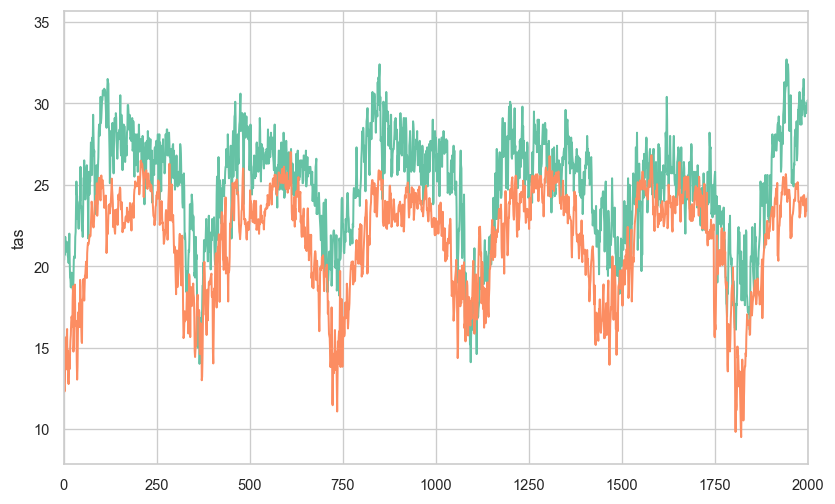

In [8]:
sns.lineplot(np.arange(sample_size), df['TAVG'])
sns.lineplot(np.arange(sample_size), df['tas'])
plt.xlim([0, 2000])
plt.show()

#### period/seasonal

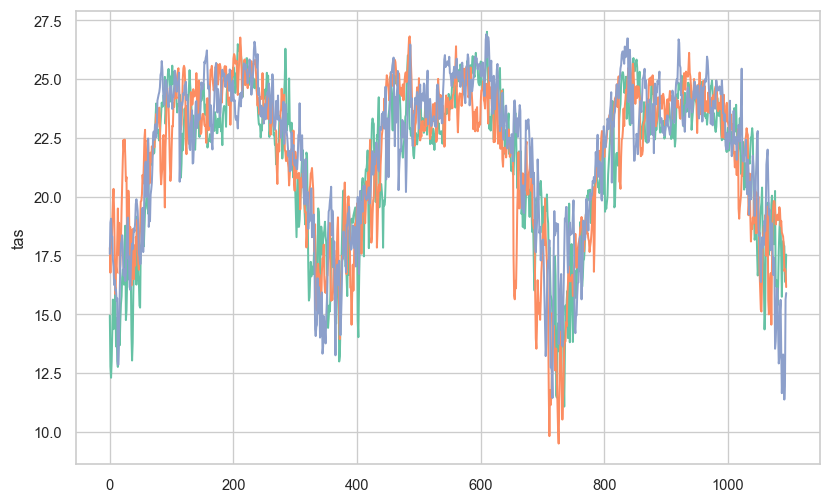

In [9]:
period_range = 365*3
x = np.arange(0, period_range)

for i in range(3):
    sns.lineplot(x, df[period_range*i:(i+1)*period_range]['tas'])
plt.show()

## preprocess function

In [10]:
def windowed_dataset_X_Y(series, window_size, shuffle_buffer, num_predict=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + num_predict, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + num_predict))
#     ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda window: (window[:-num_predict], window[-num_predict:]))

    
    X = []
    Y = []
    
    for window in ds:
        x, y = window
        X.append(x.numpy())
        Y.append(y.numpy())
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    return X, Y

## Preprocess Data

ไอเดียคือ 
- จะปรับปรุงความเอนเอียงของข้อมูลจากโมเดล (climate model) ให้ตรงกับข้อมูลที่วัดจริง
- input คือข้อมูลจากโมเดล window_size วัน เพื่อทำนายข้อมูล 1 วันให้ตรงกับข้อมูลที่วัดจริง (วันต่อไป)
- เช่น ใช้ข้อมูลวันที่ 1-5 ทำนายข้อมูลวัดจริงวันที่ 6 (ข้อมูลวันที่ 6 จากโมเดลก็จะถูกปรับความเอนเอียง)

In [11]:
split_time = sample_size - (365*5)

window_size = 30
shuffle_buffer = 1000
batch_size = 64

split_time

10228

In [12]:
train = df['tas'][:split_time]
val = df['tas'][split_time:]

In [13]:
train.shape, val.shape

((10228,), (1825,))

In [14]:
X_train, Y_train = windowed_dataset_X_Y(train, window_size, shuffle_buffer)
X_val, Y_val = windowed_dataset_X_Y(val, window_size, shuffle_buffer)

In [15]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)

In [16]:
X_train.shape, Y_train.shape

((10198, 30, 1), (10198, 1))

In [17]:
Y_train = df['TAVG'][:split_time][window_size:]

In [18]:
Y_val = df['TAVG'][split_time:][window_size:]

## Model

In [19]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, n_epoch):
        self.n_epoch = n_epoch
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == 0 or (epoch+1)%self.n_epoch == 0:
            print(f"Epoch: {epoch+1}")
            for key, value in logs.items():
                print(f"{key}: {value:.4f}", end=" \t ")
            print()

In [20]:
model = Sequential()
model.add(LSTM(1, input_shape=(window_size, 1), return_sequences=False))
model.add(Dense(1))

In [21]:
optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

In [22]:
num_epochs = 250
hist = model.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size,
                 callbacks=[CustomCallback(25)], validation_data=(X_val, Y_val), verbose=0)

Epoch: 1
loss: 25.4922 	 val_loss: 25.6040 	 
Epoch: 25
loss: 16.6638 	 val_loss: 16.7258 	 
Epoch: 50
loss: 8.6885 	 val_loss: 8.7362 	 
Epoch: 75
loss: 2.9399 	 val_loss: 2.7156 	 
Epoch: 100
loss: 1.7292 	 val_loss: 1.5242 	 
Epoch: 125
loss: 1.6827 	 val_loss: 1.5078 	 
Epoch: 150
loss: 1.6745 	 val_loss: 1.5199 	 
Epoch: 175
loss: 1.6736 	 val_loss: 1.5144 	 
Epoch: 200
loss: 1.6690 	 val_loss: 1.5115 	 
Epoch: 225
loss: 1.6673 	 val_loss: 1.5107 	 
Epoch: 250
loss: 1.6634 	 val_loss: 1.5075 	 


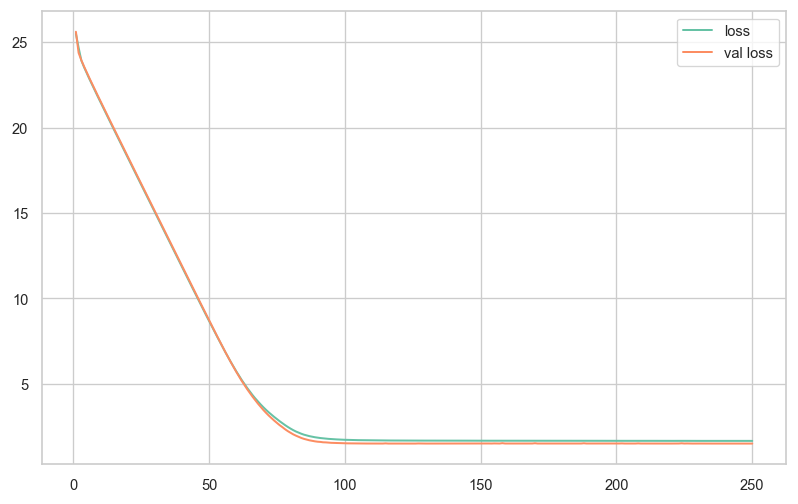

In [23]:
epochs = np.arange(1, num_epochs+1)
sns.lineplot(epochs, hist.history['loss'], label='loss')
sns.lineplot(epochs, hist.history['val_loss'], label='val loss')

## Predict

In [24]:
bias_corrected = [] 

In [25]:
for time in range(sample_size-window_size):
    x = df['tas'][time:time+window_size]
    x = np.array([x])
    x = x.reshape(x.shape[0], x.shape[1], -1)
    y = model.predict(x)
    bias_corrected.append(y)
bias_corrected = np.array(bias_corrected).squeeze()

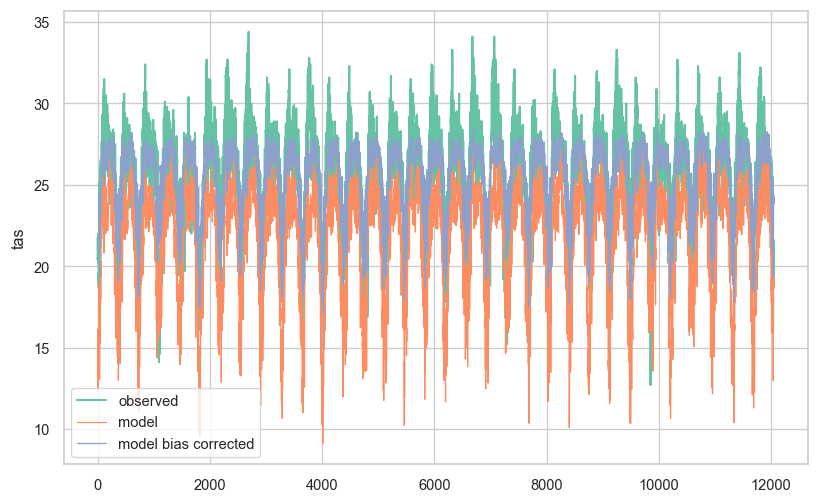

In [26]:
x = np.arange(sample_size)
sns.lineplot(x, df['TAVG'], label='observed')
sns.lineplot(x, df['tas'], label='model', linewidth=0.75)
sns.lineplot(x[window_size:], bias_corrected, label='model bias corrected', linewidth=0.75)

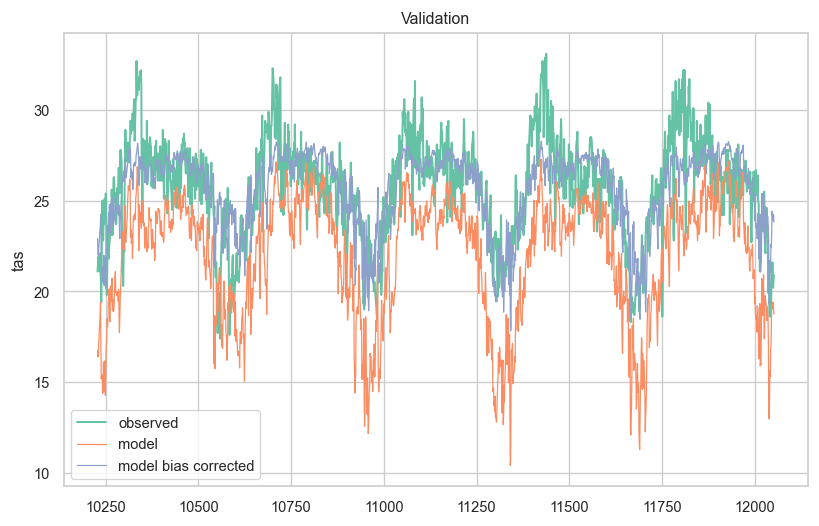

In [27]:
x = np.arange(split_time, sample_size)
sns.lineplot(x, df['TAVG'][split_time:], label='observed')
sns.lineplot(x, val, label='model', linewidth=0.75)
sns.lineplot(x, bias_corrected[split_time-window_size:], label='model bias corrected', linewidth=0.75)
plt.title('Validation')
plt.show()

## Evaluation

### model bias

In [28]:
mae(df['TAVG'][split_time:], df['tas'][split_time:])

3.815611780821898

### simple method - bias
bias corrected = model + c

In [29]:
c = (df['TAVG'][:split_time] - df['tas'][:split_time]).mean()

In [30]:
mae(df['TAVG'][split_time:], df['tas'][split_time:]+c)

1.9280342085224014

### LSTM - bias

In [31]:
mae(df['TAVG'][split_time:], bias_corrected[split_time-window_size:])

1.51818441960583

Text(0, 0.5, 'observed value')

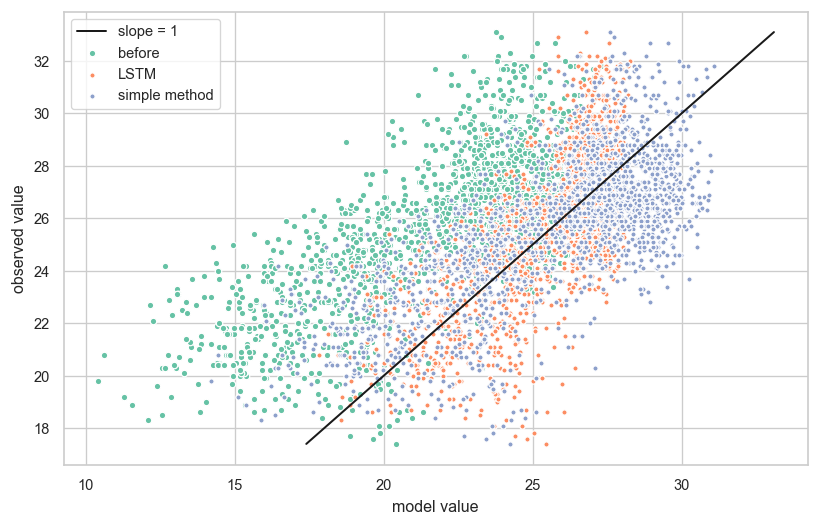

In [35]:
sns.scatterplot(df['tas'][split_time:], df['TAVG'][split_time:], label='before', s=15)
sns.scatterplot(bias_corrected[split_time-window_size:], df['TAVG'][split_time:], label='LSTM', s=10)
sns.scatterplot(df['tas'][split_time:]+c, df['TAVG'][split_time:], label='simple method', s=10)
sns.lineplot(df['TAVG'][split_time:], df['TAVG'][split_time:], label='slope = 1', color='k')
plt.xlabel('model value')
plt.ylabel('observed value')

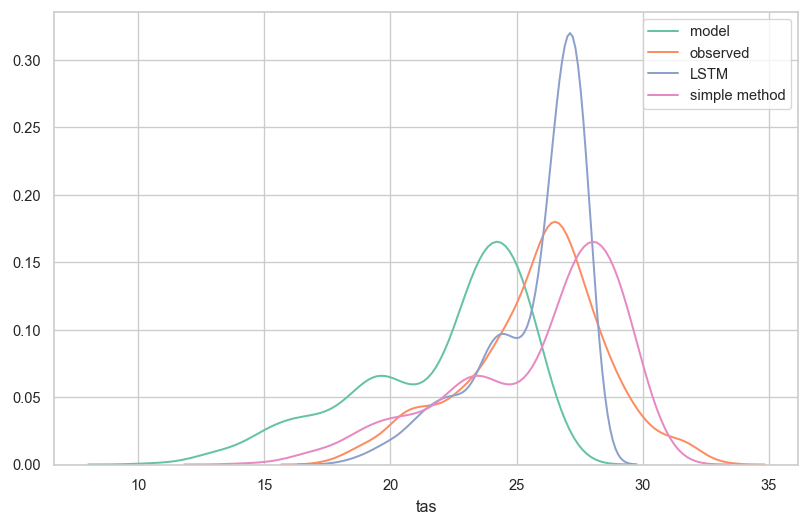

In [33]:
sns.distplot(df['tas'][split_time:], hist=False, label='model')
sns.distplot(df['TAVG'][split_time:], hist=False, label='observed')
sns.distplot(bias_corrected[split_time-window_size:], hist=False, label='LSTM')
sns.distplot(df['tas'][split_time:]+c, hist=False, label='simple method')
plt.legend()

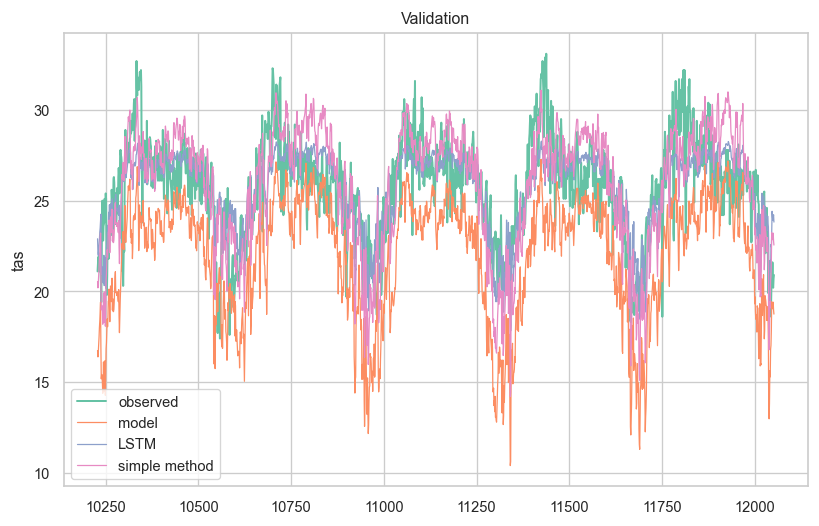

In [34]:
x = np.arange(split_time, sample_size)
sns.lineplot(x, df['TAVG'][split_time:], label='observed')
sns.lineplot(x, val, label='model', linewidth=0.75)
sns.lineplot(x, bias_corrected[split_time-window_size:], label='LSTM', linewidth=0.75)
sns.lineplot(x, df['tas'][split_time:]+c, label='simple method', linewidth=0.75)
plt.title('Validation')
plt.show()